##Mount Goolge Drive

In [1]:
# link to google drive

####from google.colab import drive
#drive.mount('/content/gdrive/')
####drive.mount("/content/gdrive/", force_remount=True)

### Ejecutar Codigo en Google Drive

In [2]:
####%cd "/content/gdrive/My Drive/Deep_Network_unmixing/version_1"

In [3]:
%ls
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"]= '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

CAVE.ipynb  Data_set/  MAIN.py  PAVIA.ipynb


# Data Set
shows the dataset details

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 102)


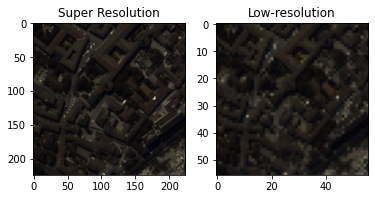

(<matplotlib.axes._subplots.AxesSubplot at 0x7f00d51cf250>,
 Text(0.5, 1.0, 'Low-resolution'),
 None)

In [4]:
Hy = scipy.io.loadmat('Data_set/pavia_cort.mat')['hyperimg']
[m,n,l] = Hy.shape
Hy = tf.expand_dims(Hy,0)
print(Hy.shape)


Sup_Fact =4
RGB_bands = [33, 24, 5]

Hy = Hy.numpy()
most = np.squeeze(Hy)[:,:,RGB_bands]
plt.subplot(1,2,1),plt.imshow(most), plt.title('Super Resolution')

def Desimation_Super(x,factor,w):
    Aux = tf.image.resize(x,[int(np.round(w/factor)),int(np.round(w/factor))],method=tf.image.ResizeMethod.BICUBIC)
    return Aux

y = Desimation_Super(Hy,Sup_Fact,m)
pp = np.squeeze(y)
pp = pp[:,:,RGB_bands]
plt.subplot(1,2,2),plt.imshow(pp), plt.title('Low-resolution'),plt.show()


# Resutls Linear Results


In [5]:
from MAIN import *
import os.path as path
# prepared folders
Path = 'Results_2'
try:
  os.stat(Path)
except:
  os.mkdir(Path)

# Define the importants variables and training


In [6]:
import time
def My_training(blocks=1,losses=0,losses_weight=0,ouput_net=0):

    Input_v = tf.image.resize(y,[m,n]).numpy()
    # Important Parameter and Hyper-parameters
    learning_rate_value = [2e-3,1.5e-3,1e-3]
    Perturbed = [0,0.01,0.05] #[0.01]

    # fixed for now
    regularization_abund = 1
    rank = [6]
    Abundance_layer = [32] # for a fixed 5 layer
    Number_layers  = 4
    show_every = 50
    Global_max_epoch =1000
    psnr_deep = []
    best_psnr = 0
    Best_metric = []
    plot_results = 1

    for Abun_layer in Abundance_layer:
        for rank_v in rank:
            for lrn in learning_rate_value:
                for rho in Perturbed:
                    psnr_deep = []
                    best_psnr = 0
                    best_Endm = []
                    Best_metric = []
                    best_Abun = []
                    best_img = []
                    Info_path = str(blocks)+'_Full_proposed_perturbed='+str(rho)+'lr='+str(lrn)+'Rank='+str(rank_v)
                    Real_path = (Path+'/'+Info_path)
                    try:
                        os.stat(Real_path)
                    except:
                        os.mkdir(Real_path)
                    # Model values
                    model = LMM_Net_reconstruction(input_size =(m,n,l), L=l,rank=rank_v,Layer_depth=Abun_layer,number_layer=Number_layers,decimation=Sup_Fact)
                    # Optimization parameters
                    optimizad = tf.keras.optimizers.Adam(learning_rate=lrn, beta_1=0.9, beta_2=0.9, amsgrad=False);
                    model.compile(optimizer=optimizad, loss=losses,loss_weights=losses_weight)

                    contad_decr = 0
                    for i in range(Global_max_epoch):
                        print('Iteration = ' + str(i)+' of max= '+str(Global_max_epoch) +' -- '+ Info_path +'\n')
                        clear_output(wait=True)
                        if(rho>0):
                          input_ent = Input_v + rho*np.random.normal(0,1,(1,m,n,l))
                        else:
                          input_ent = Input_v
                        model.fit(input_ent, ouput_net, epochs = show_every,batch_size=1,verbose=0)

                        # ouputs Models
                        temporal = model.get_weights()
                        Endm = np.squeeze(temporal[-1]) # aca cambio
                        H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final_last').output])
                        #Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
                        Image_recon = K.function([model.layers[0].input], [model.get_layer('estimation').output])
                        Img_recon = np.squeeze(np.asarray(Image_recon(input_ent)))
                        rest_h = np.squeeze(np.asarray(H_high(input_ent)))

                        # evaluation model
                        results_metrics=performance(np.squeeze(Hy),Img_recon)
                        psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

                        if(plot_results==1):
                            pp = Img_recon[:,:,RGB_bands]
                            plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
                            plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')
                            plt.show()
                            plt.subplot(1, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
                            plt.subplot(1, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
                            plt.subplot(1, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
                            plt.subplot(1, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')
                            plt.show()

                            plt.subplot(1,1,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
                            plt.show()

                            plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),
                            plt.ylabel('PSNR'),plt.show()

                        if(best_psnr>=psnr_deep[-1]):
                            contad_decr +=1
                        else:
                            best_psnr = psnr_deep[-1]
                            best_Endm = Endm
                            Best_metric = results_metrics
                            best_Abun = rest_h
                            best_img  = Img_recon
                            contad_decr = 0

                        print('PNSR = '+ str(psnr_deep[-1])+ ', contador_decr= ' + str(contad_decr)+ ', best= ' + str(best_psnr)+'\n')

                        if (contad_decr>30):
                            scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                            scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                            #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                            break
                    else:
                        scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                        scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                        #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)
                        continue

                    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
                    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
                    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

    scipy.io.savemat(Real_path+"/Final_results.mat", {'Abundace': rest_h,'Endmember': Endm,'Img_recon':Img_recon, 'PSNR':psnr_deep[-1],'results_metrics':results_metrics})
    scipy.io.savemat(Real_path+"/Best_results.mat", {'Abundace': best_Abun,'Endmember': best_Endm,'Img_recon':best_img, 'PSNR':best_psnr,'Best_metric':Best_metric})
    #save_results(Path,results_metrics,Best_metric,rho,lrn,rank,regularization_abund,Abun_layer,layer_num)

#

# Multiples block
# 3 linear block
With a single loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


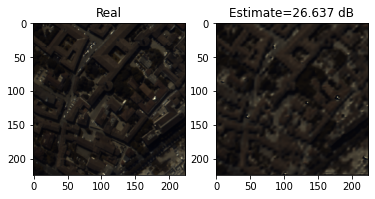

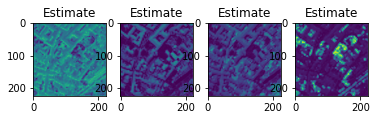

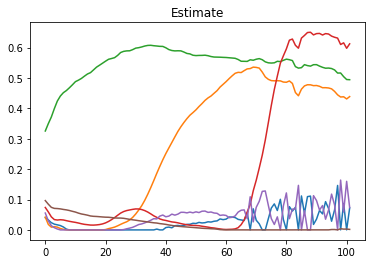

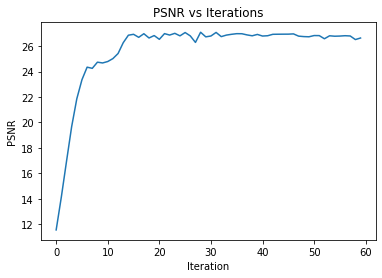

PNSR = 26.637287139892578, contador_decr= 31, best= 27.0904803276062



FileNotFoundError: [Errno 2] No such file or directory: 'Results_2/3_Full_proposed_perturbed=0lr=0.002Rank=6/Final_results.mat'

In [7]:


def LMM_Net_reconstruction(pretrained_weights=None, input_size = (150,150,1), L=102, rank = 8,Layer_depth=16,number_layer=4,initial=None, decimation=2):
    inputs = Input(input_size)
    # block 1
    Ab = Abund_net_residual(inputs,rank,name='1',L=Layer_depth,number_layer=number_layer)
    hy = Endmemebers_Layer(L=L, rank=rank,initicial=initial)(Ab)

    # block 2
    Ab2 = Abund_net_residual(hy,rank,name='2',L=Layer_depth,number_layer=number_layer)
    hy2 = Endmemebers_Layer(L=L, rank=rank,initicial=initial)(Ab2)

    # block 3
    Ab3 = Abund_net_residual(hy2,rank,name='_last',L=Layer_depth,number_layer=number_layer)
    hy3 = Endmemebers_Layer(L=L, rank=rank,initicial=initial,name='estimation')(Ab3)

    final =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy3)
    final2 =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy2)
    final3 =Lambda(lambda x: Desimation_Super(x,decimation,input_size[0])) (hy)

    model = Model(inputs, [final,final2,final3,Ab,Ab2,Ab3])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model


losses=['mean_squared_error', 'mean_squared_error','mean_squared_error',Abundance_loss(),Abundance_loss(),Abundance_loss()]
losses_weight = [1,1,1,1,1,1]

ouput_net = [y,y,y, np.ones((1,m,n)),np.ones((1,m,n)),np.ones((1,m,n))]
My_training(blocks=3,losses=losses,losses_weight=losses_weight,ouput_net=ouput_net)